In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist, to_onehot
import numpy as np
import os 

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
root_folder = 'FC_CAAE_results'
fixed_folder = root_folder + '/Fixed_results/'
recon_folder = root_folder + '/Recon_results/'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)
os.mkdir(recon_folder)

In [4]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
                lambda x: x.to(device)
           ])

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

lr = 0.0001
prior_size = 10
train_epoch = 1000
batch_size = 250
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh)
fixed_z = torch.randn((10, prior_size)).repeat((1,10)).view(-1, prior_size).to(device)
fixed_z_label = to_onehot(torch.tensor(list(range(10))).repeat((10)), 10).to(device)
fixed_data, fixed_label = next(iter(test_loader))
fixed_data = fixed_data[:100].to(device)
fixed_label = to_onehot(fixed_label[:100], 10).to(device)

cuda:0


In [6]:
data, label = next(iter(train_loader))

In [7]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, 
                 last_fn=None, first_fn=None, device='cpu'):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        if first_fn is not None:
            layers.append(first_fn)
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        self.to(device)
        
    def forward(self, x, y=None):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        if y is not None:
            x = torch.cat([x, y], dim=1)
        return self.model(x)

In [8]:
Enc = FullyConnected([28*28, 1024, 1024, prior_size], activation_fn=nn.LeakyReLU(0.2), flatten=True, device=device)
Dec = FullyConnected([prior_size+10, 1024, 1024, 28*28], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh(), device=device)
Disc = FullyConnected([prior_size+10, 1024, 1024, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), device=device)

Enc_optimizer = optim.Adam(Enc.parameters(), lr=lr)
Dec_optimizer = optim.Adam(Dec.parameters(), lr=lr)
Disc_optimizer = optim.Adam(Disc.parameters(), lr=lr)

In [9]:
train_log = {'E': [],'AE': [], 'D': []}
test_log = {'E': [],'AE': [], 'D': []}

In [10]:
batch_zeros = torch.zeros((batch_size, 1)).to(device)
batch_ones = torch.ones((batch_size, 1)).to(device)

In [11]:
def train(epoch, Enc, Dec, Disc, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, label) in enumerate(train_loader):
        label = to_onehot(label, 10, device)
        # train D
        Enc.zero_grad()
        Disc.zero_grad()
        
        z = torch.randn((batch_size, prior_size)).to(device)
        z_label = to_onehot(np.random.randint(0, 10, (batch_size)), 10, device)

        fake_pred = Disc(Enc(data), label)
        true_pred = Disc(z, z_label)

        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        Disc_loss = 0.5*(fake_loss + true_loss)
        
        Disc_loss.backward()
        Disc_optimizer.step()
        
        # train AE
        Enc.zero_grad()
        Dec.zero_grad()
        Disc.zero_grad()
        
        z = torch.randn((batch_size, prior_size))
        z_label = to_onehot(np.random.randint(0, 10, (batch_size)), 10)
        
        latent = Enc(data)
        reconstructed = Dec(latent, label).view(-1, 1, 28, 28)
        fake_pred = Disc(latent, label)
        
        Enc_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_ones)
        AE_loss = F.mse_loss(reconstructed, data)
        G_loss = AE_loss + Enc_loss
        
        G_loss.backward()
        Dec_optimizer.step()
        Enc_optimizer.step()
            
        if batch_idx % 100 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = 'E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(Enc_loss.item(), AE_loss.item(), Disc_loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = 'E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(Enc_loss.item(), AE_loss.item(), Disc_loss.item())
        print(line + losses)
        log['E'].append(Enc_loss.item())
        log['AE'].append(AE_loss.item())
        log['D'].append(Disc_loss.item())

In [12]:
def test(Enc, Dec, Disc, loader, epoch, log=None):
    test_size = len(loader)
    E_loss = 0.
    AE_loss = 0.
    D_loss = 0.
    test_loss = {'E': 0., 'AE': 0., 'D': 0.}
    with torch.no_grad():
        for data, label in loader:
            label = to_onehot(label, 10, device)
            z = torch.randn((batch_size, prior_size)).to(device)
            z_label = to_onehot(np.random.randint(0, 10, (batch_size)), 10, device)
            latent = Enc(data)
            reconstructed = Dec(latent, label).view(-1, 1, 28, 28)
            fake_pred = Disc(latent, label)
            true_pred = Disc(z, z_label)
        
            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros).item()
            true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones).item()
            
            D_loss += 0.5*(fake_loss + true_loss)
            E_loss += F.binary_cross_entropy_with_logits(fake_pred, batch_ones).item()
            AE_loss += F.mse_loss(reconstructed, data)
            
        E_loss /= test_size
        D_loss /= test_size
        AE_loss /= test_size

        fixed_gen = Dec(fixed_z, fixed_z_label).cpu().data.numpy().reshape(100, 1, 28, 28)
        plot_mnist(fixed_gen, (10, 10), True, fixed_folder + '%03d.png' % epoch)
        fixed_reconstruction = Dec(Enc(fixed_data), fixed_label).cpu().data.numpy().reshape(100, 1, 28, 28)
        plot_mnist(fixed_reconstruction, (10, 10), True, recon_folder + '%03d.png' % epoch)
        
    report = 'Test losses. E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(E_loss, AE_loss, D_loss)
    print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses E: 0.6576, AE: 0.9264, D: 0.6946
Train Epoch: 1 [25000/50000 (50%)]	Losses E: 0.6185, AE: 0.2794, D: 5.3271
Train Epoch: 1 [50000/50000 (100%)]	Losses E: 0.8802, AE: 0.2894, D: 1.2715


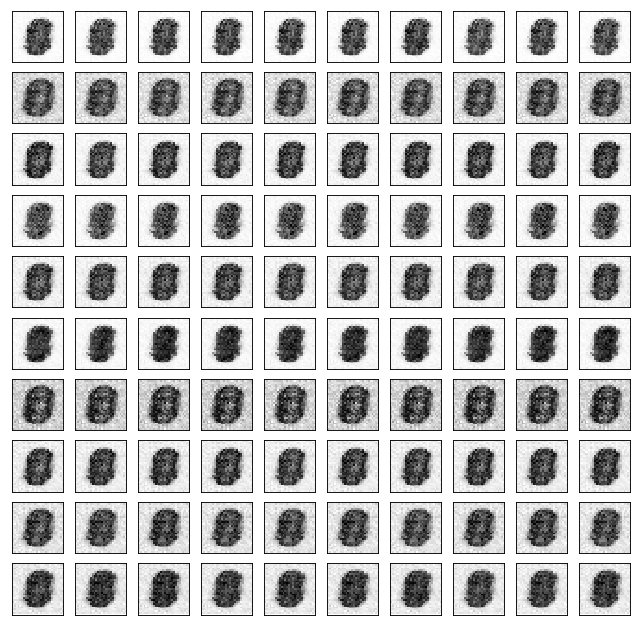

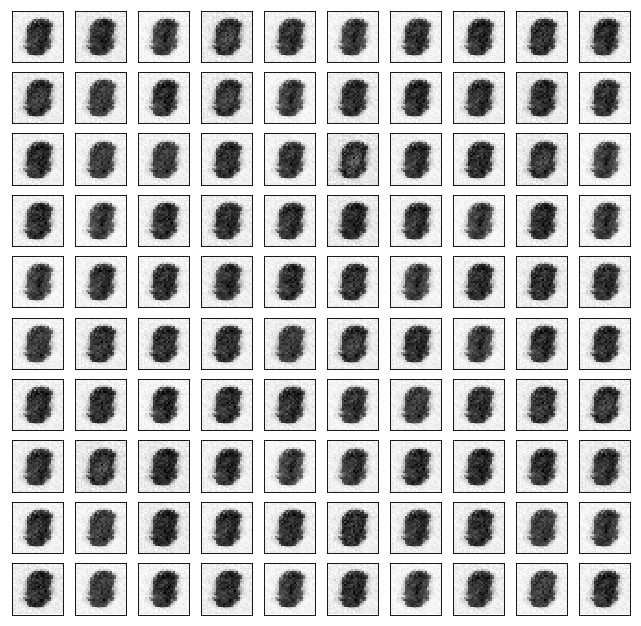

Test losses. E: 0.8777, AE: 0.2832, D: 1.2782
Train Epoch: 2 [0/50000 (0%)]	Losses E: 0.8846, AE: 0.2869, D: 1.3128
Train Epoch: 2 [25000/50000 (50%)]	Losses E: 0.6335, AE: 0.2524, D: 0.9209
Train Epoch: 2 [50000/50000 (100%)]	Losses E: 1.3243, AE: 0.2471, D: 0.6655


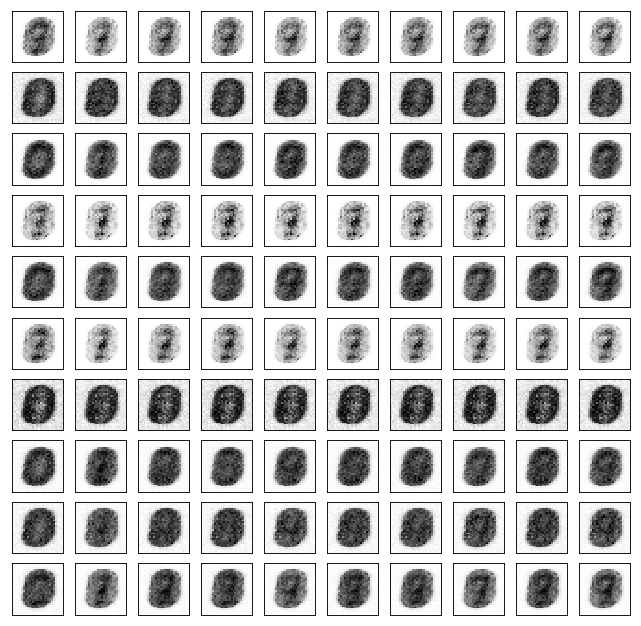

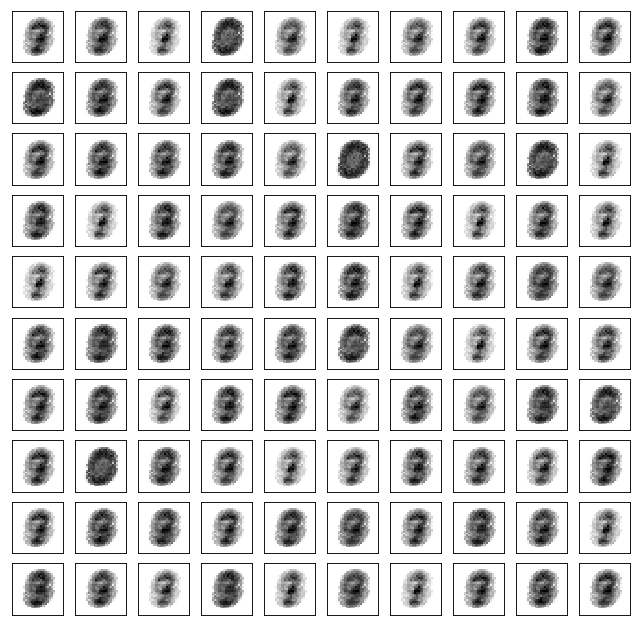

Test losses. E: 1.1644, AE: 0.2522, D: 0.6323
Train Epoch: 3 [0/50000 (0%)]	Losses E: 1.4364, AE: 0.2440, D: 0.6408
Train Epoch: 3 [25000/50000 (50%)]	Losses E: 0.6389, AE: 0.2484, D: 0.8561
Train Epoch: 3 [50000/50000 (100%)]	Losses E: 0.5267, AE: 0.2374, D: 0.7704


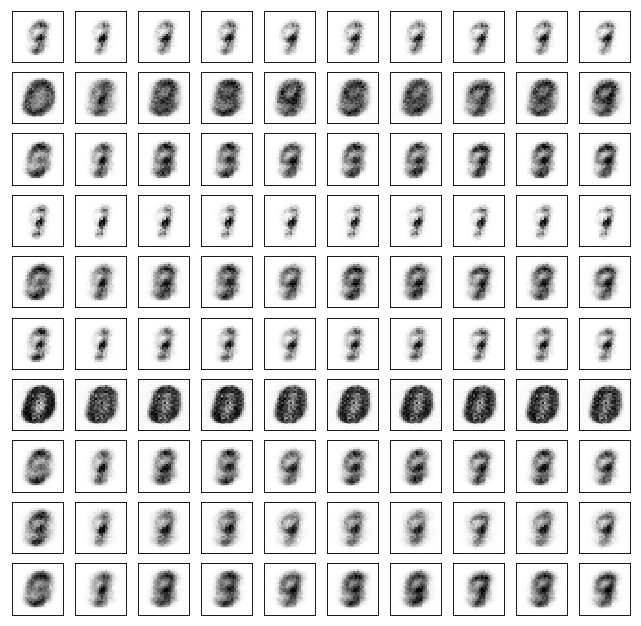

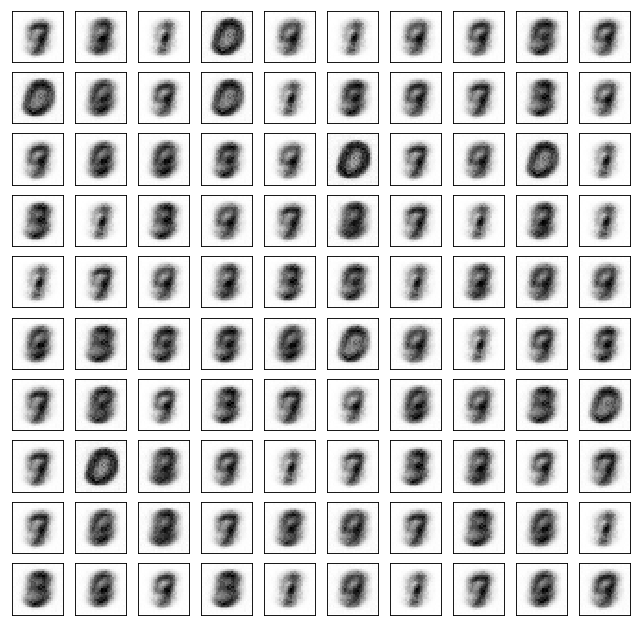

Test losses. E: 0.5100, AE: 0.2362, D: 0.7643
Train Epoch: 4 [0/50000 (0%)]	Losses E: 0.5248, AE: 0.2424, D: 0.7695
Train Epoch: 4 [25000/50000 (50%)]	Losses E: 1.0070, AE: 0.2277, D: 0.7387
Train Epoch: 4 [50000/50000 (100%)]	Losses E: 0.6085, AE: 0.2151, D: 0.7696


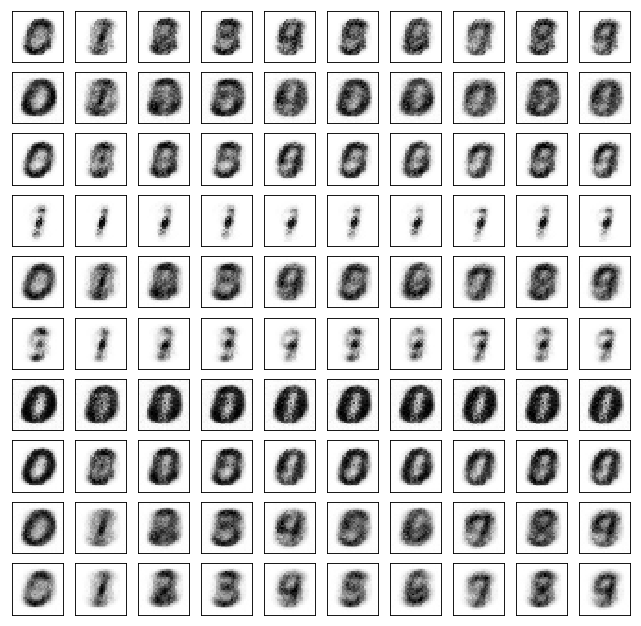

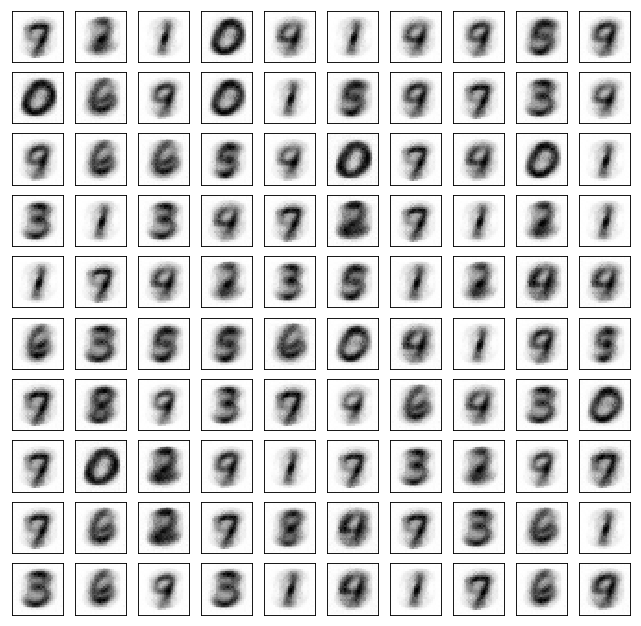

Test losses. E: 0.6042, AE: 0.2181, D: 0.7631
Train Epoch: 5 [0/50000 (0%)]	Losses E: 0.6056, AE: 0.2225, D: 0.7658
Train Epoch: 5 [25000/50000 (50%)]	Losses E: 0.5960, AE: 0.2115, D: 0.6973
Train Epoch: 5 [50000/50000 (100%)]	Losses E: 1.0205, AE: 0.2044, D: 0.6543


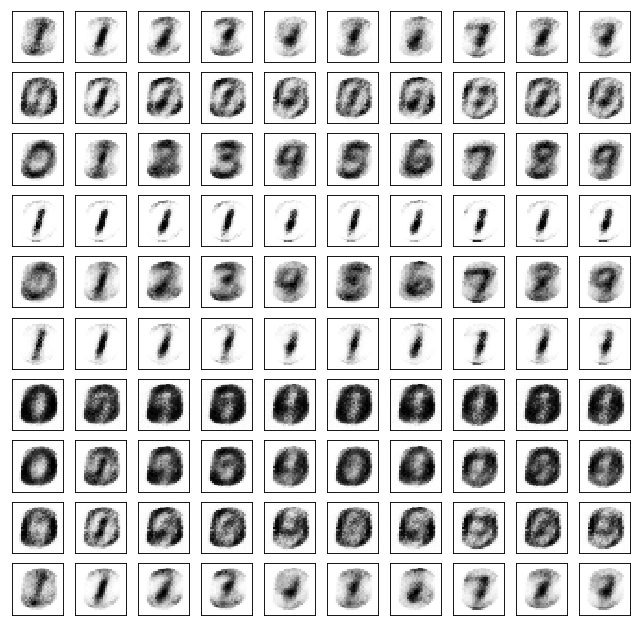

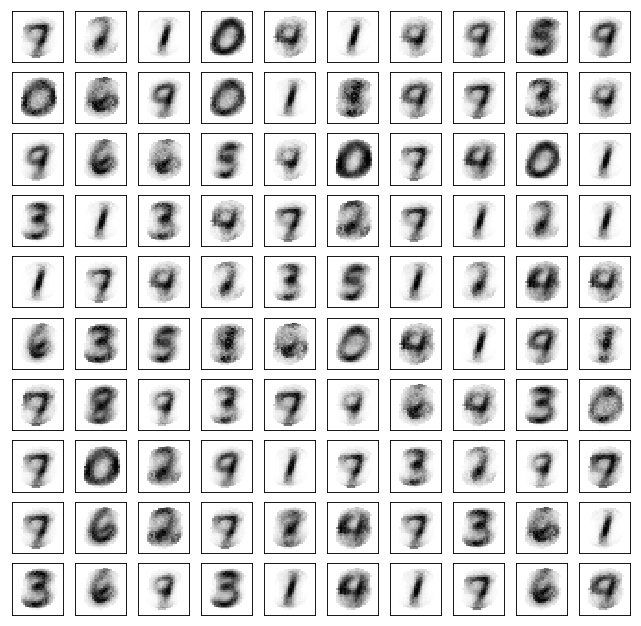

Test losses. E: 0.9445, AE: 0.2086, D: 0.6652
Train Epoch: 6 [0/50000 (0%)]	Losses E: 0.9976, AE: 0.2116, D: 0.6737
Train Epoch: 6 [25000/50000 (50%)]	Losses E: 0.6075, AE: 0.1968, D: 0.7627
Train Epoch: 6 [50000/50000 (100%)]	Losses E: 0.5865, AE: 0.1953, D: 0.7174


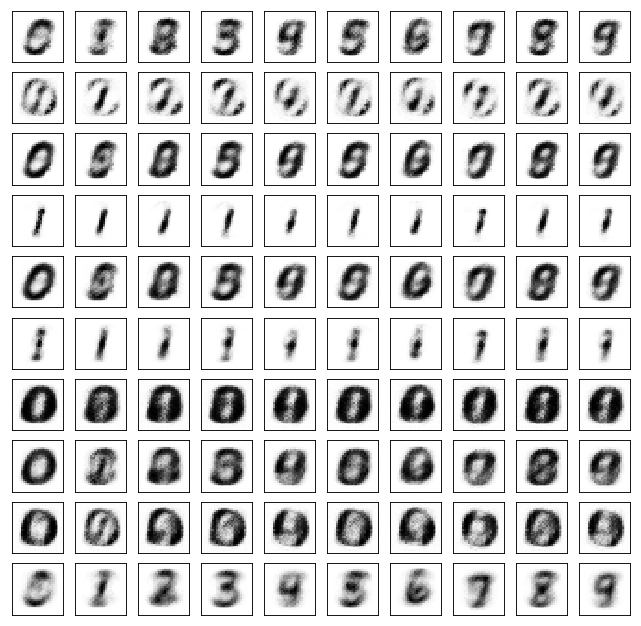

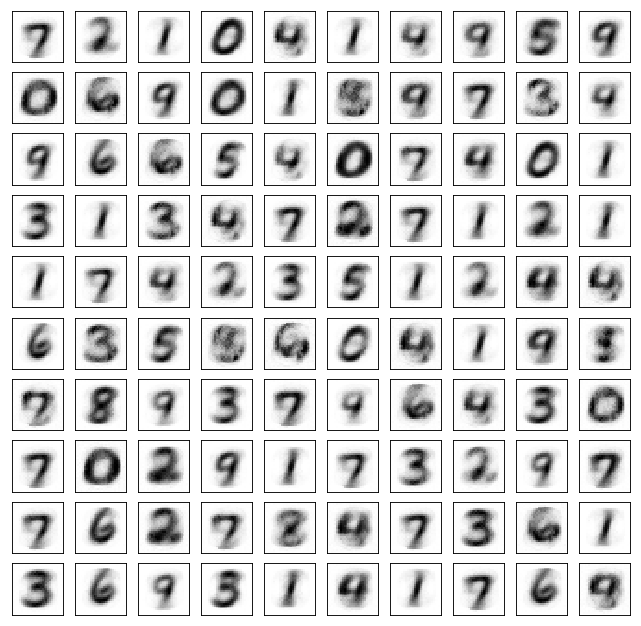

Test losses. E: 0.5840, AE: 0.1939, D: 0.7094
Train Epoch: 7 [0/50000 (0%)]	Losses E: 0.5844, AE: 0.1987, D: 0.7147
Train Epoch: 7 [25000/50000 (50%)]	Losses E: 0.5869, AE: 0.1934, D: 0.7483
Train Epoch: 7 [50000/50000 (100%)]	Losses E: 0.7182, AE: 0.1907, D: 0.7328


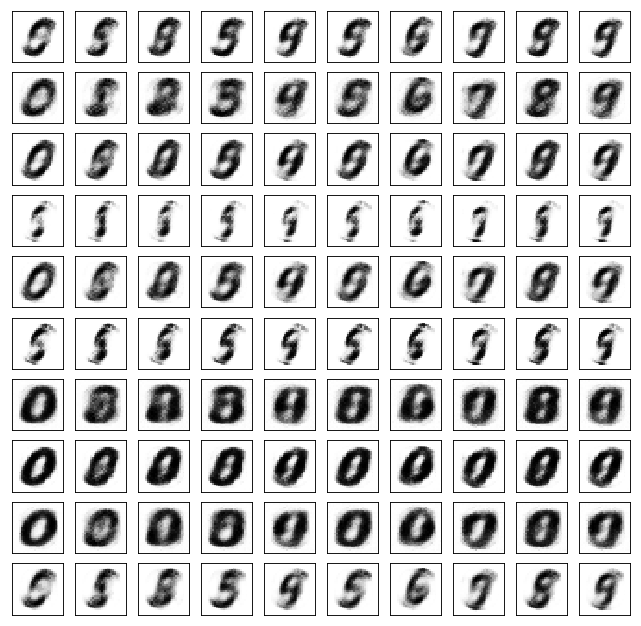

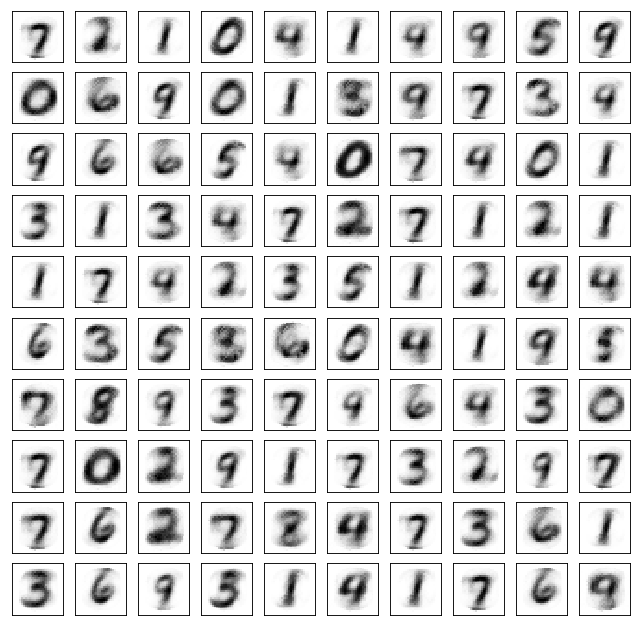

Test losses. E: 0.6966, AE: 0.1908, D: 0.7390
Train Epoch: 8 [0/50000 (0%)]	Losses E: 0.7052, AE: 0.1892, D: 0.7387
Train Epoch: 8 [25000/50000 (50%)]	Losses E: 0.6243, AE: 0.1784, D: 0.7043
Train Epoch: 8 [50000/50000 (100%)]	Losses E: 0.6186, AE: 0.1810, D: 0.6782


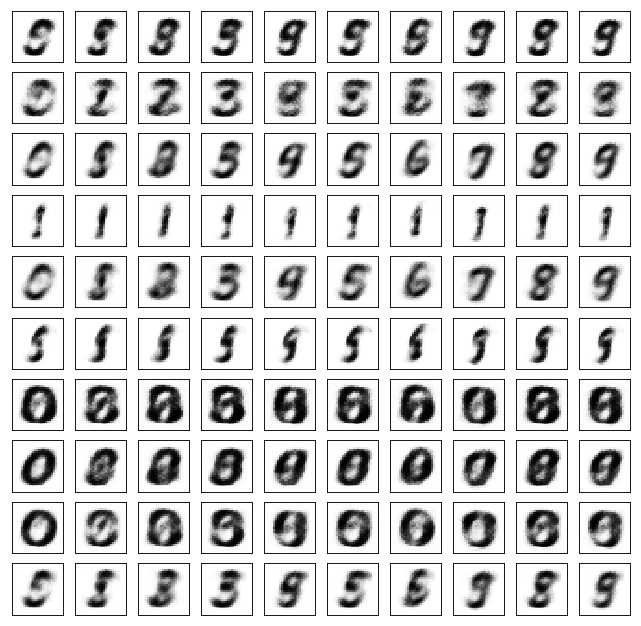

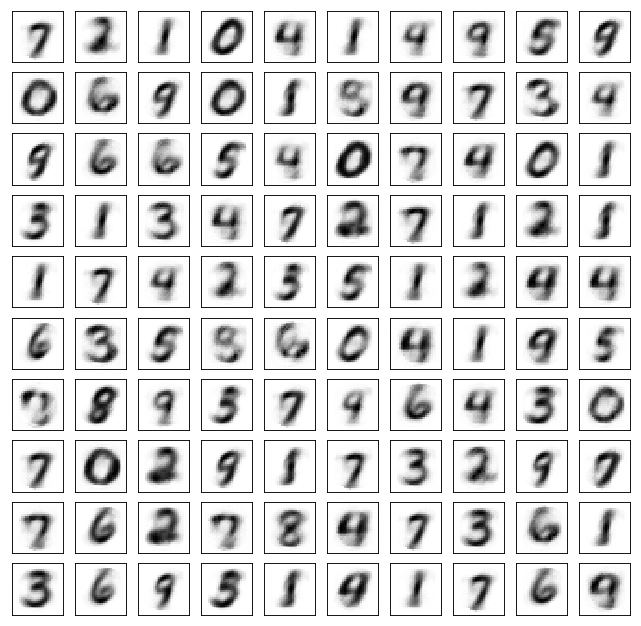

Test losses. E: 0.6122, AE: 0.1850, D: 0.6748
Train Epoch: 9 [0/50000 (0%)]	Losses E: 0.6114, AE: 0.1740, D: 0.6787
Train Epoch: 9 [25000/50000 (50%)]	Losses E: 0.6228, AE: 0.1901, D: 0.8128
Train Epoch: 9 [50000/50000 (100%)]	Losses E: 0.6434, AE: 0.1767, D: 0.7258


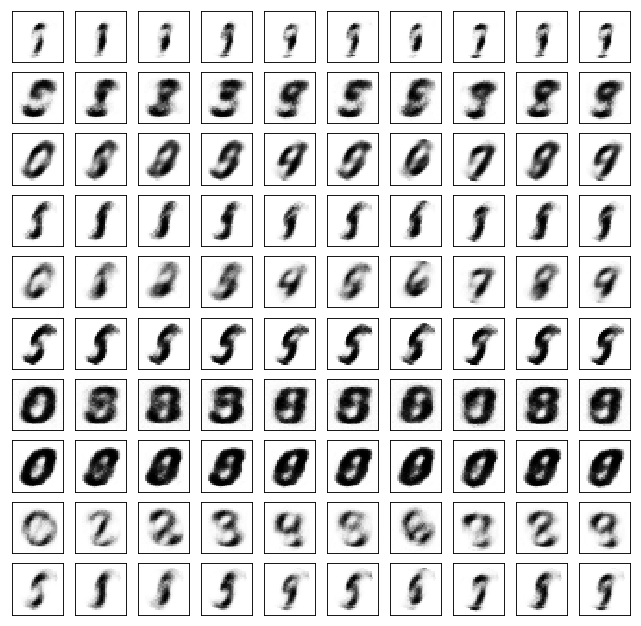

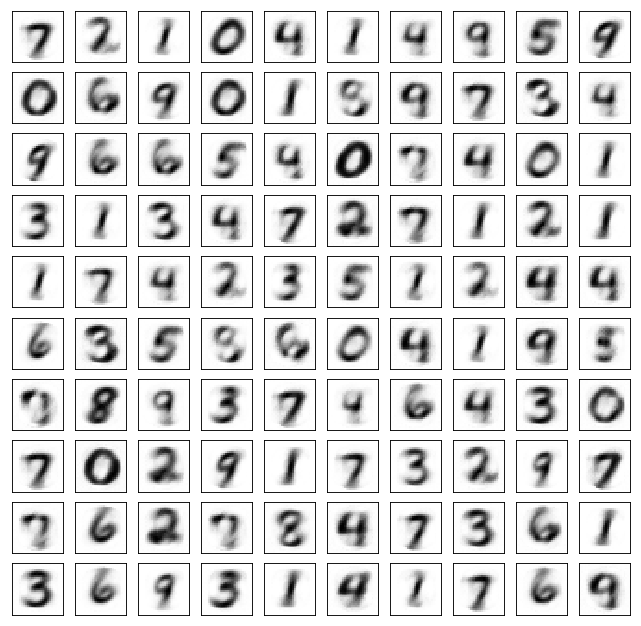

Test losses. E: 0.6428, AE: 0.1755, D: 0.7214
Train Epoch: 10 [0/50000 (0%)]	Losses E: 0.6419, AE: 0.1753, D: 0.7253
Train Epoch: 10 [25000/50000 (50%)]	Losses E: 0.6243, AE: 0.1667, D: 0.6852
Train Epoch: 10 [50000/50000 (100%)]	Losses E: 0.5809, AE: 0.1693, D: 0.8187


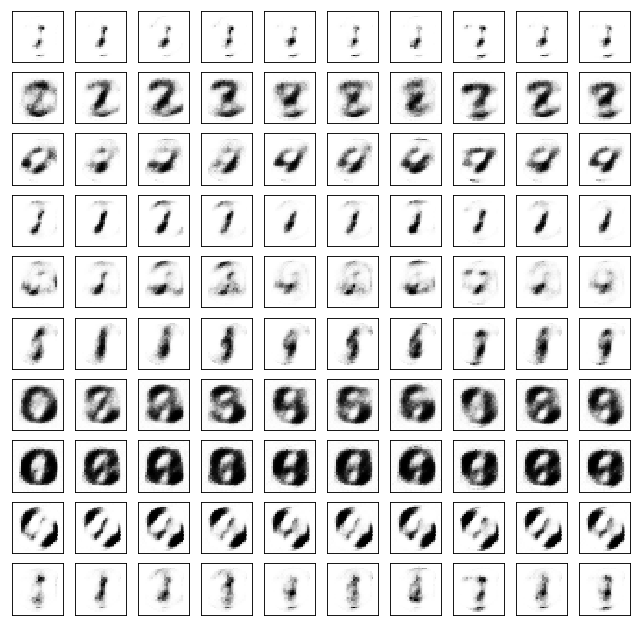

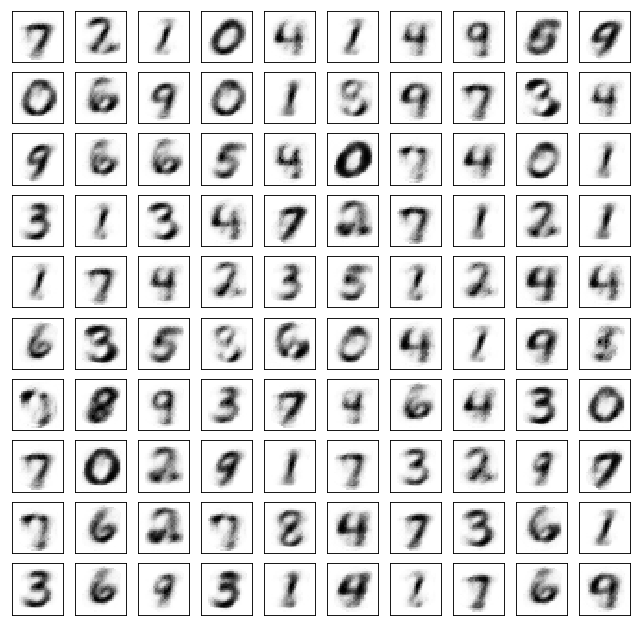

Test losses. E: 0.5580, AE: 0.1702, D: 0.8246
Train Epoch: 11 [0/50000 (0%)]	Losses E: 0.5673, AE: 0.1761, D: 0.8371
Train Epoch: 11 [25000/50000 (50%)]	Losses E: 0.6460, AE: 0.1583, D: 0.7343
Train Epoch: 11 [50000/50000 (100%)]	Losses E: 0.6041, AE: 0.1560, D: 0.7024


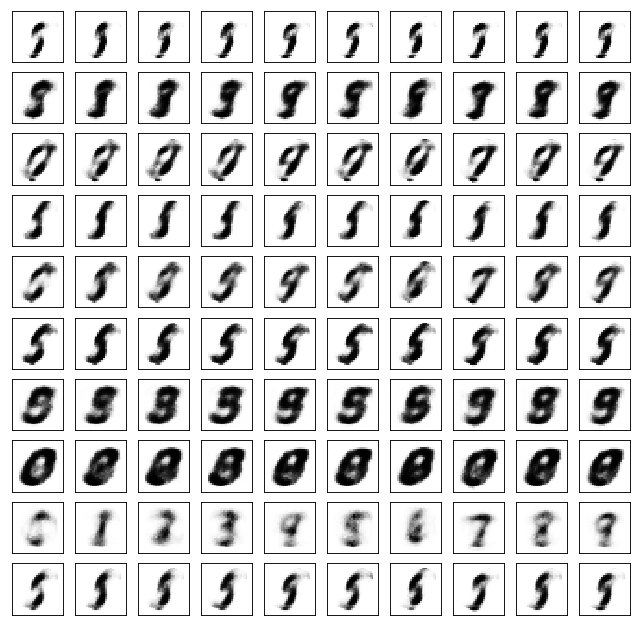

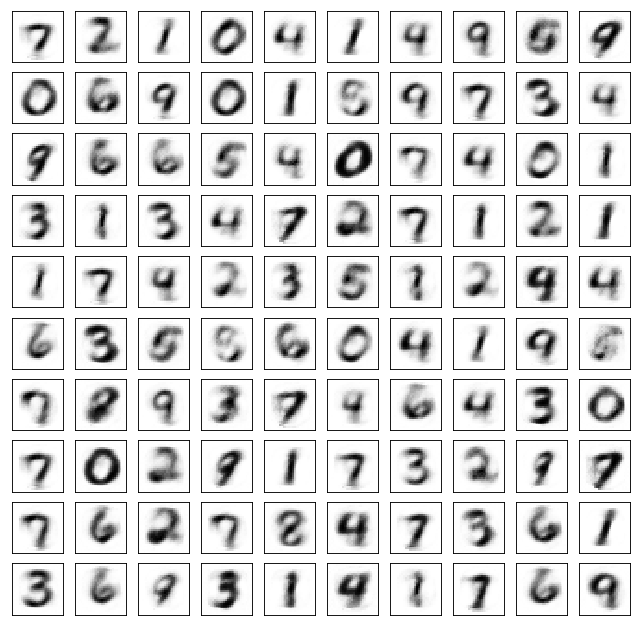

Test losses. E: 0.5971, AE: 0.1582, D: 0.7031
Train Epoch: 12 [0/50000 (0%)]	Losses E: 0.6027, AE: 0.1573, D: 0.7039
Train Epoch: 12 [25000/50000 (50%)]	Losses E: 0.6924, AE: 0.1693, D: 0.7247
Train Epoch: 12 [50000/50000 (100%)]	Losses E: 0.6674, AE: 0.1514, D: 0.7321


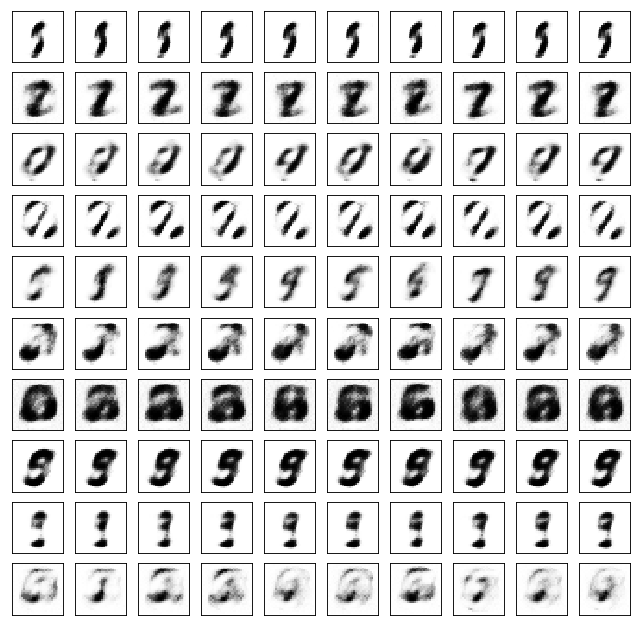

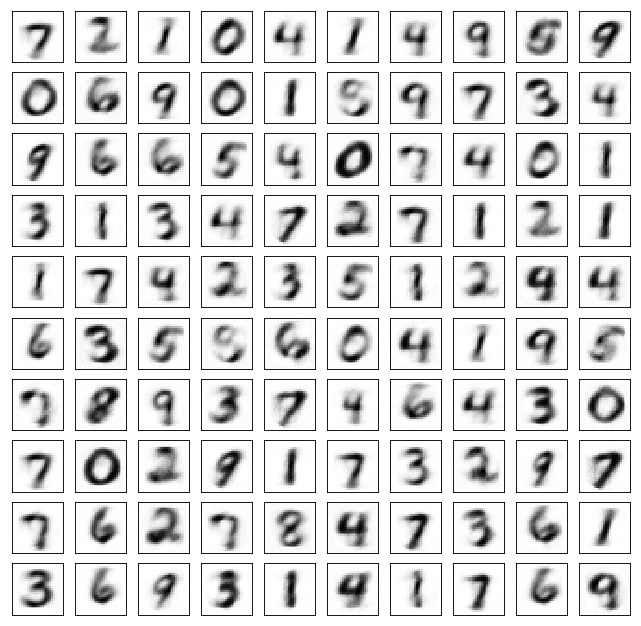

Test losses. E: 0.6652, AE: 0.1540, D: 0.7284
Train Epoch: 13 [0/50000 (0%)]	Losses E: 0.6636, AE: 0.1554, D: 0.7284
Train Epoch: 13 [25000/50000 (50%)]	Losses E: 0.6199, AE: 0.1479, D: 0.6912
Train Epoch: 13 [50000/50000 (100%)]	Losses E: 0.8148, AE: 0.1705, D: 0.7034


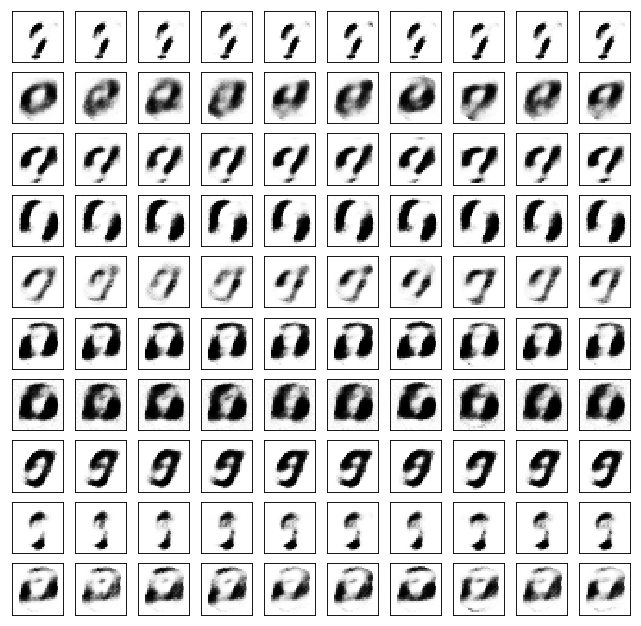

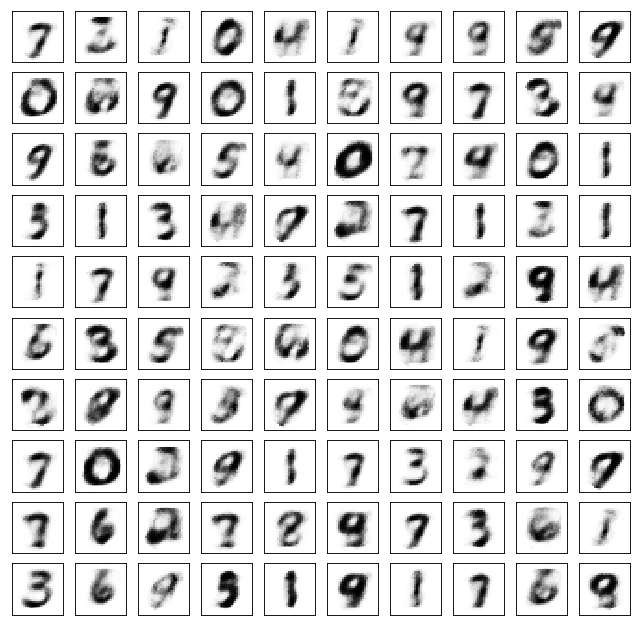

Test losses. E: 0.7356, AE: 0.1700, D: 0.6801
Train Epoch: 14 [0/50000 (0%)]	Losses E: 0.8867, AE: 0.1635, D: 0.6716
Train Epoch: 14 [25000/50000 (50%)]	Losses E: 0.6881, AE: 0.1428, D: 0.7193
Train Epoch: 14 [50000/50000 (100%)]	Losses E: 0.6391, AE: 0.1378, D: 0.6946


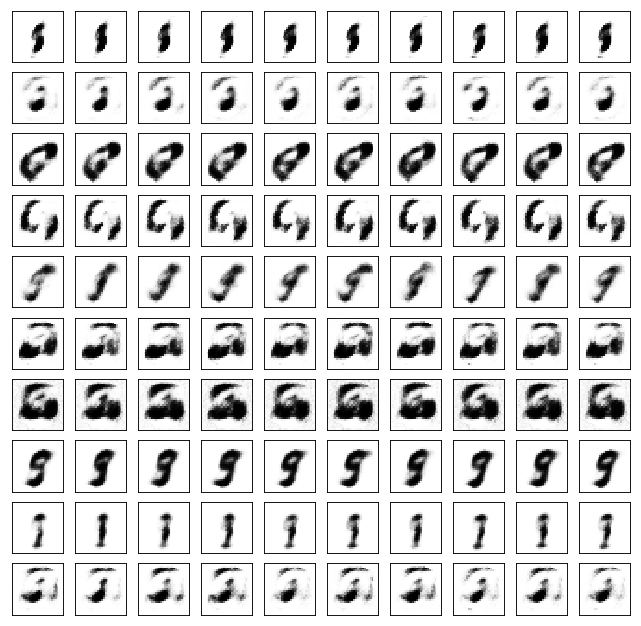

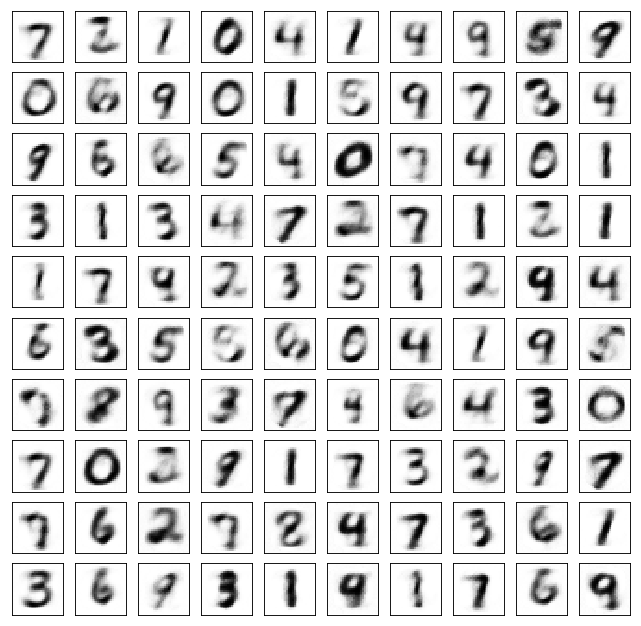

Test losses. E: 0.6383, AE: 0.1403, D: 0.6913
Train Epoch: 15 [0/50000 (0%)]	Losses E: 0.6390, AE: 0.1354, D: 0.6900
Train Epoch: 15 [25000/50000 (50%)]	Losses E: 0.9768, AE: 0.1610, D: 0.6589
Train Epoch: 15 [50000/50000 (100%)]	Losses E: 0.6912, AE: 0.1357, D: 0.7162


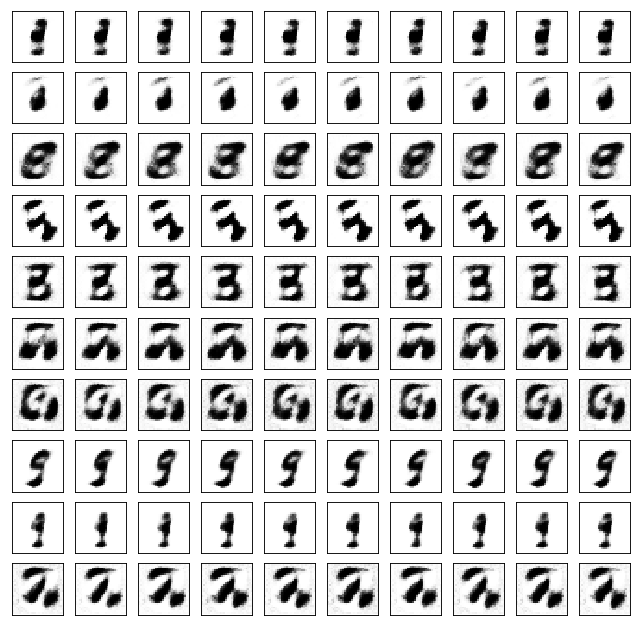

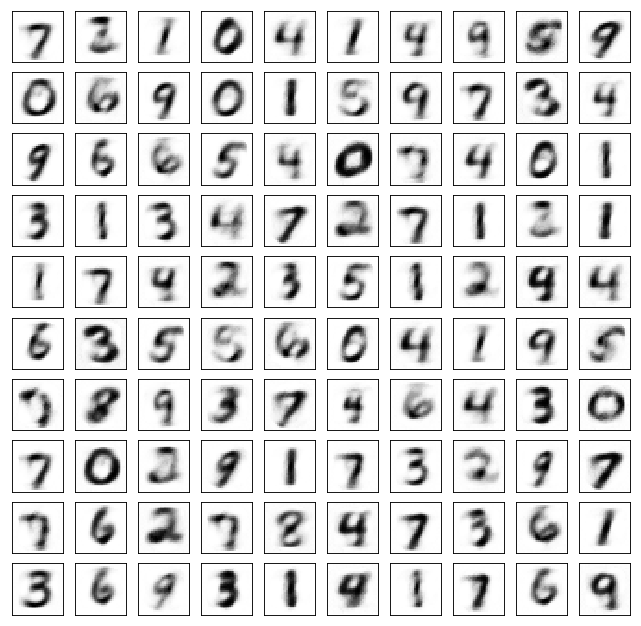

Test losses. E: 0.6904, AE: 0.1377, D: 0.7137
Train Epoch: 16 [0/50000 (0%)]	Losses E: 0.6899, AE: 0.1382, D: 0.7174
Train Epoch: 16 [25000/50000 (50%)]	Losses E: 0.6418, AE: 0.1304, D: 0.6877
Train Epoch: 16 [50000/50000 (100%)]	Losses E: 0.7244, AE: 0.1456, D: 0.7096


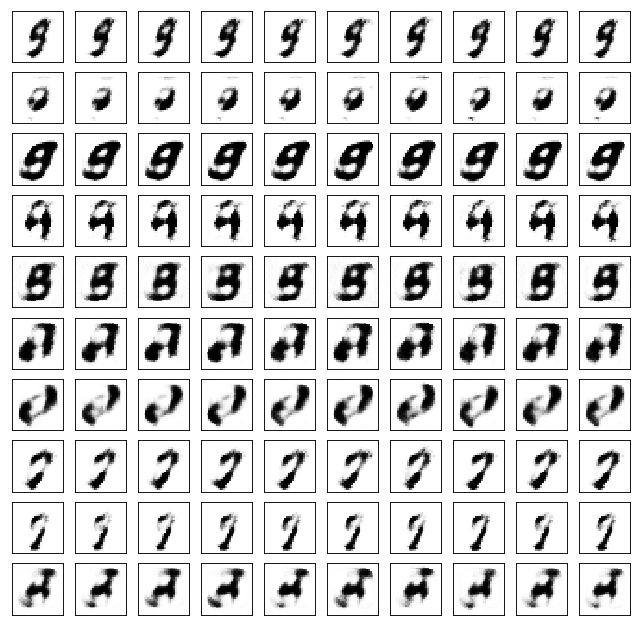

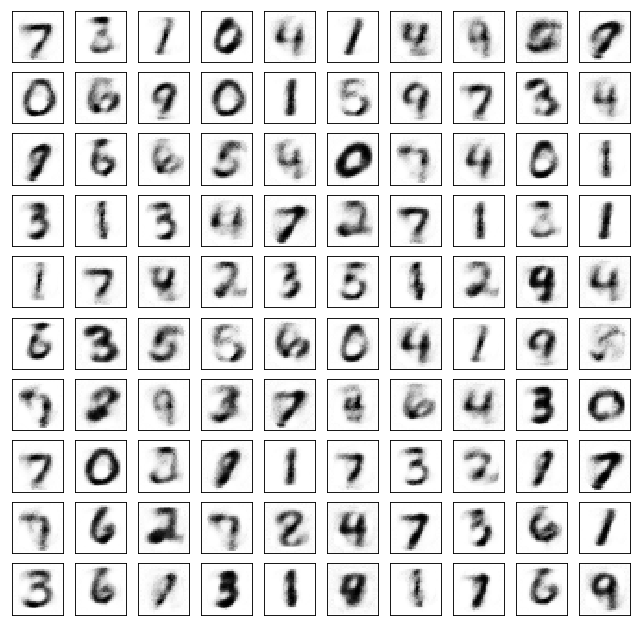

Test losses. E: 0.6943, AE: 0.1444, D: 0.7149
Train Epoch: 17 [0/50000 (0%)]	Losses E: 0.7208, AE: 0.1456, D: 0.7075
Train Epoch: 17 [25000/50000 (50%)]	Losses E: 0.6842, AE: 0.1358, D: 0.7254
Train Epoch: 17 [50000/50000 (100%)]	Losses E: 0.6329, AE: 0.1302, D: 0.6881


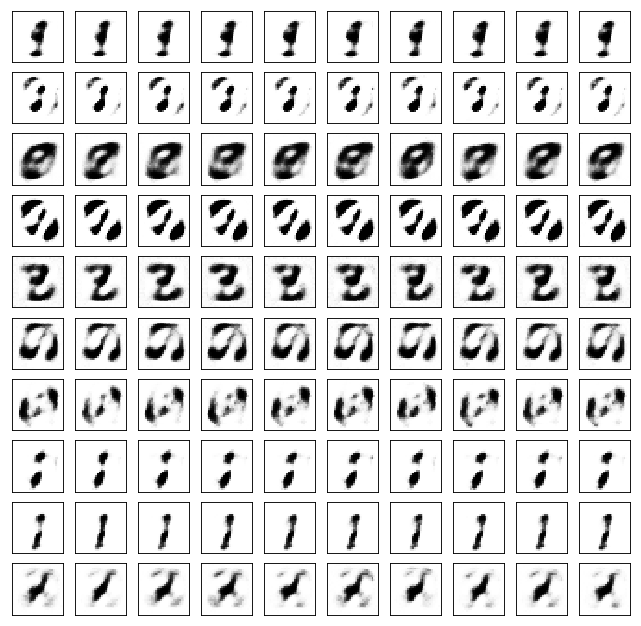

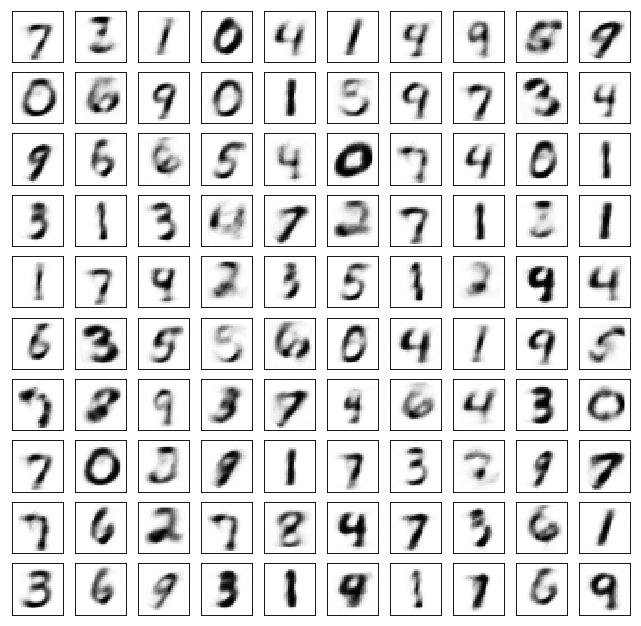

Test losses. E: 0.6316, AE: 0.1280, D: 0.6890
Train Epoch: 18 [0/50000 (0%)]	Losses E: 0.6309, AE: 0.1210, D: 0.6891
Train Epoch: 18 [25000/50000 (50%)]	Losses E: 0.6891, AE: 0.1597, D: 0.7272
Train Epoch: 18 [50000/50000 (100%)]	Losses E: 0.6829, AE: 0.1301, D: 0.7222


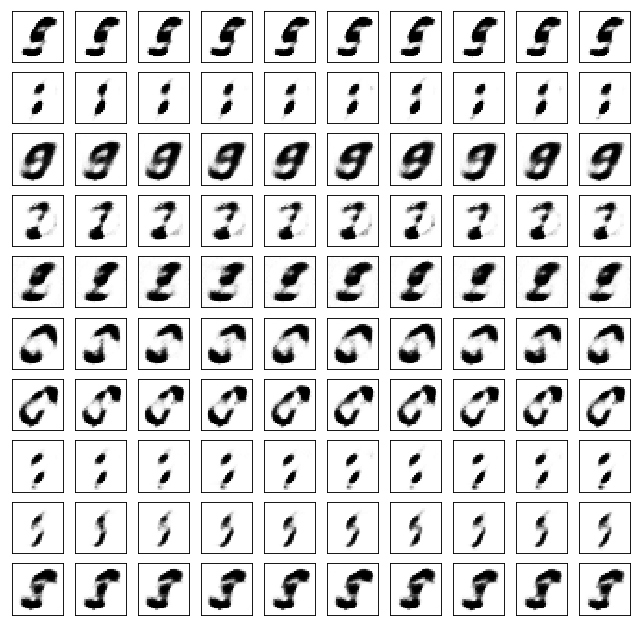

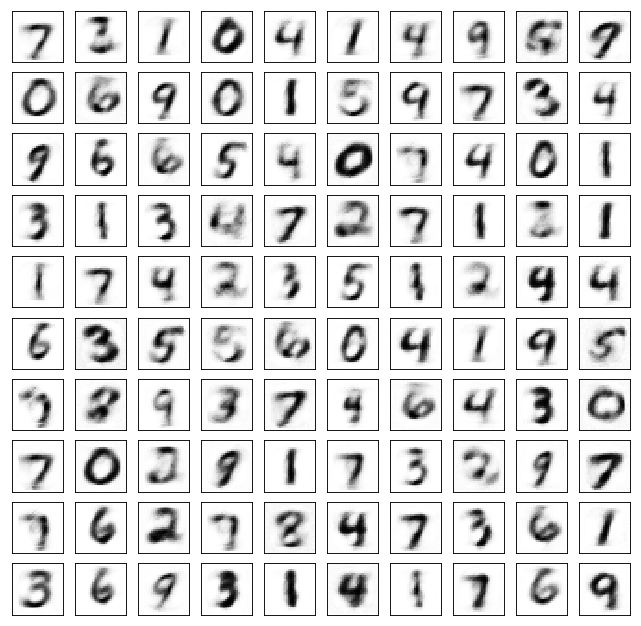

Test losses. E: 0.6821, AE: 0.1303, D: 0.7208
Train Epoch: 19 [0/50000 (0%)]	Losses E: 0.6800, AE: 0.1325, D: 0.7226
Train Epoch: 19 [25000/50000 (50%)]	Losses E: 0.6829, AE: 0.1270, D: 0.6799
Train Epoch: 19 [50000/50000 (100%)]	Losses E: 0.6710, AE: 0.1459, D: 0.7001


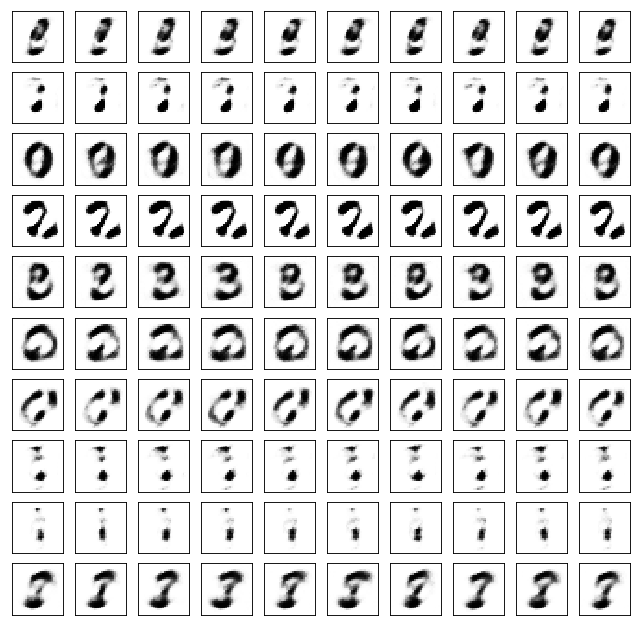

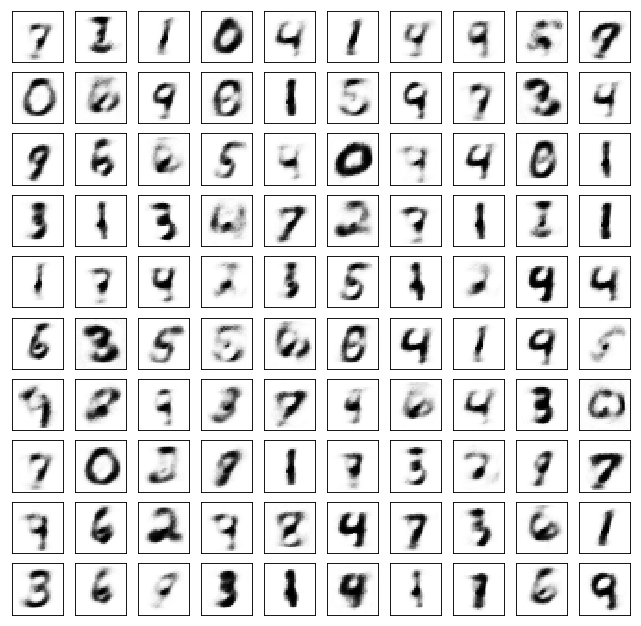

Test losses. E: 0.6606, AE: 0.1398, D: 0.6974
Train Epoch: 20 [0/50000 (0%)]	Losses E: 0.6673, AE: 0.1423, D: 0.6981
Train Epoch: 20 [25000/50000 (50%)]	Losses E: 0.7243, AE: 0.1248, D: 0.7070
Train Epoch: 20 [50000/50000 (100%)]	Losses E: 0.6444, AE: 0.1244, D: 0.6988


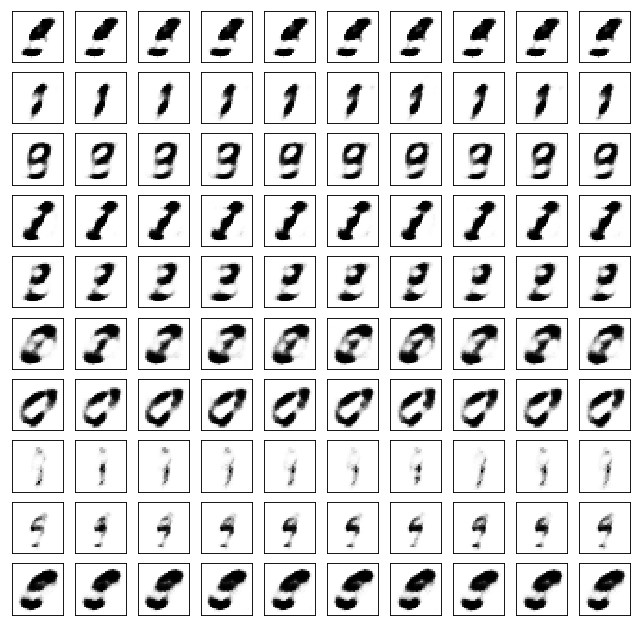

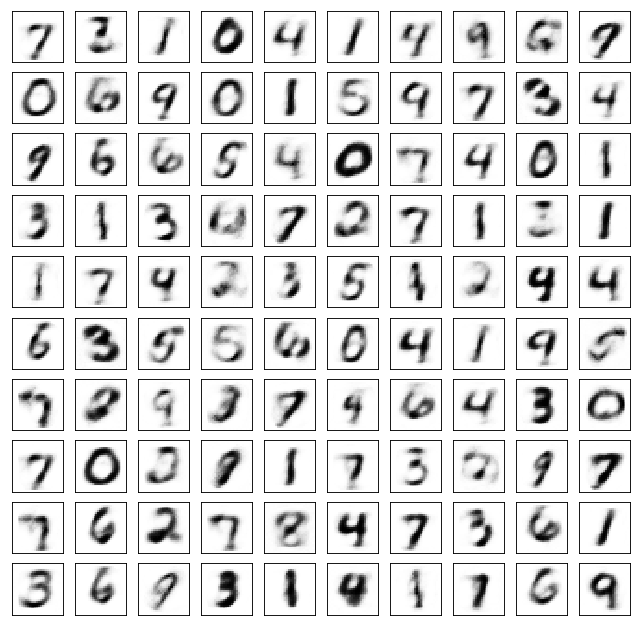

Test losses. E: 0.6406, AE: 0.1195, D: 0.6986
Train Epoch: 21 [0/50000 (0%)]	Losses E: 0.6395, AE: 0.1149, D: 0.7011
Train Epoch: 21 [25000/50000 (50%)]	Losses E: 0.6272, AE: 0.1382, D: 0.7267
Train Epoch: 21 [50000/50000 (100%)]	Losses E: 0.6932, AE: 0.1256, D: 0.7296


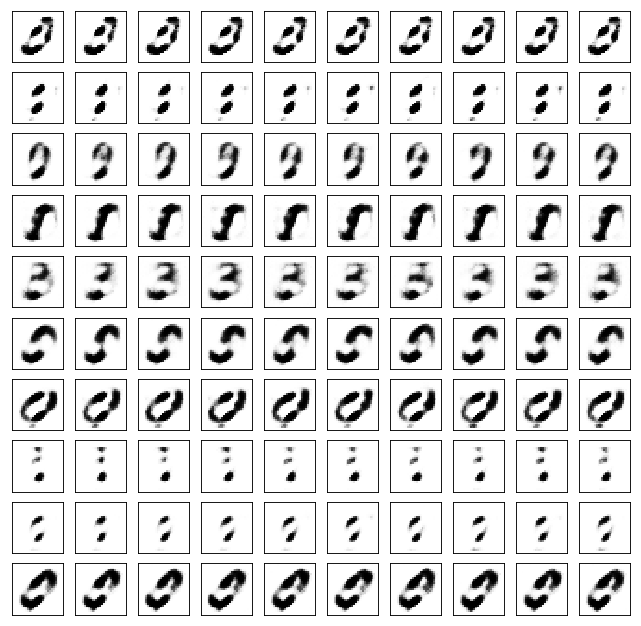

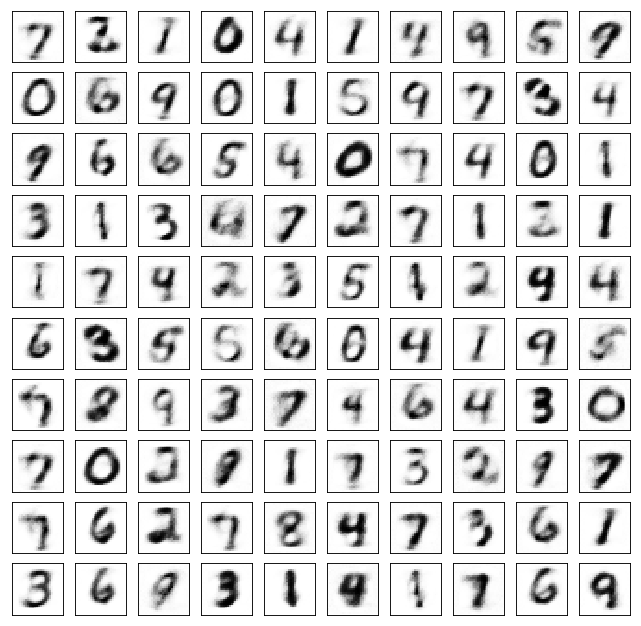

Test losses. E: 0.6953, AE: 0.1238, D: 0.7242
Train Epoch: 22 [0/50000 (0%)]	Losses E: 0.7003, AE: 0.1293, D: 0.7251
Train Epoch: 22 [25000/50000 (50%)]	Losses E: 0.7138, AE: 0.1134, D: 0.6859
Train Epoch: 22 [50000/50000 (100%)]	Losses E: 0.6998, AE: 0.1364, D: 0.6888


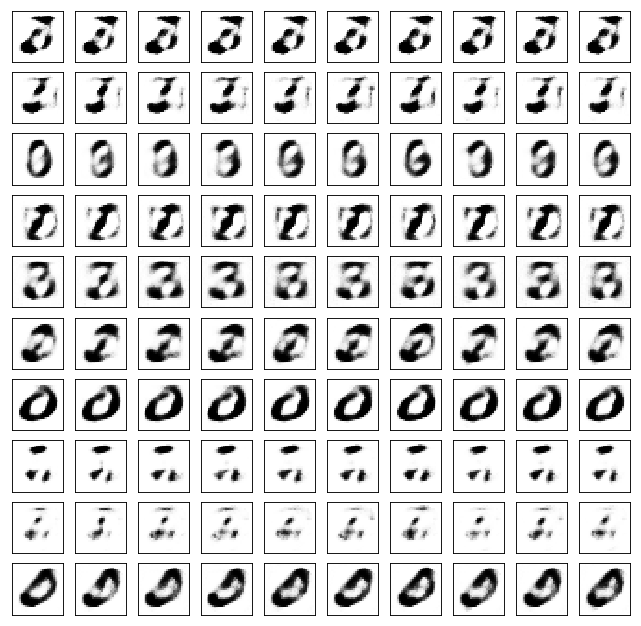

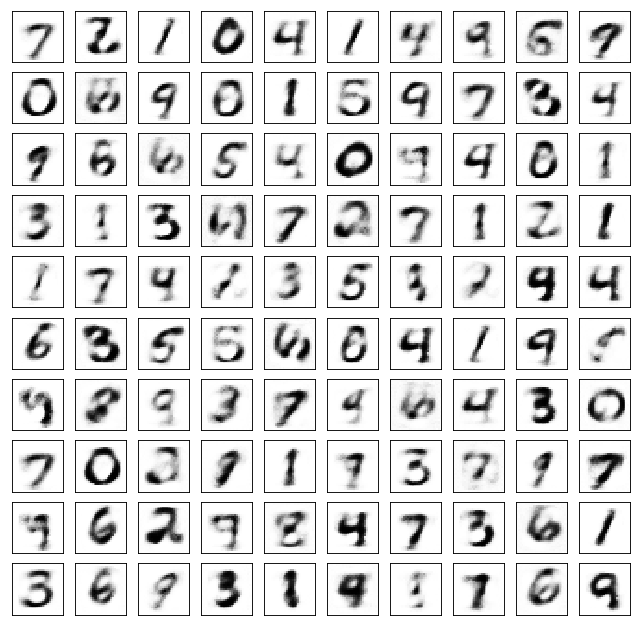

Test losses. E: 0.6906, AE: 0.1345, D: 0.6902
Train Epoch: 23 [0/50000 (0%)]	Losses E: 0.6936, AE: 0.1341, D: 0.6923
Train Epoch: 23 [25000/50000 (50%)]	Losses E: 0.6830, AE: 0.1139, D: 0.7190
Train Epoch: 23 [50000/50000 (100%)]	Losses E: 0.6394, AE: 0.1230, D: 0.7064


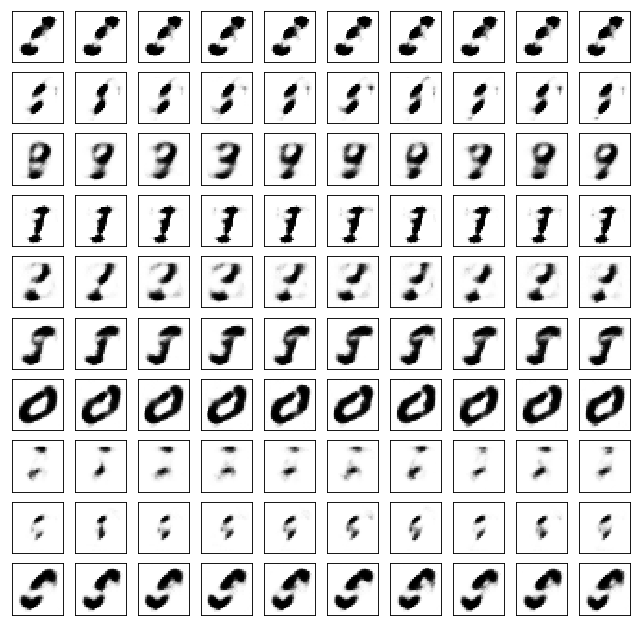

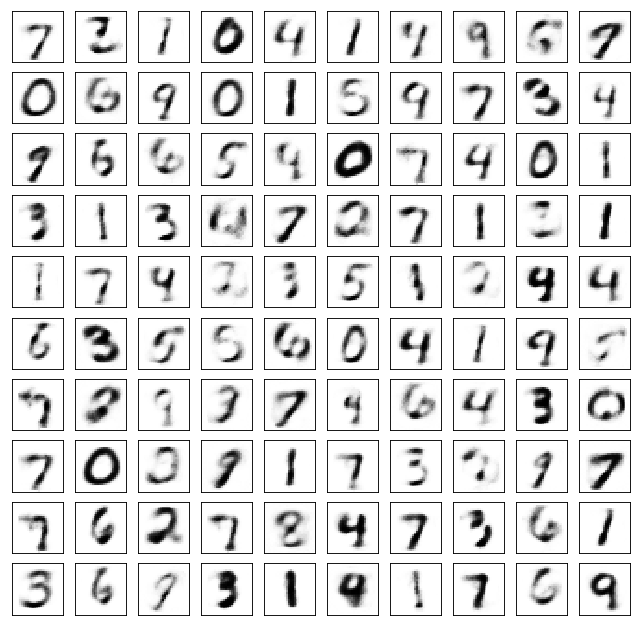

Test losses. E: 0.6366, AE: 0.1223, D: 0.7067
Train Epoch: 24 [0/50000 (0%)]	Losses E: 0.6432, AE: 0.1294, D: 0.7067
Train Epoch: 24 [25000/50000 (50%)]	Losses E: 0.7173, AE: 0.1421, D: 0.6960
Train Epoch: 24 [50000/50000 (100%)]	Losses E: 0.6967, AE: 0.1153, D: 0.6981


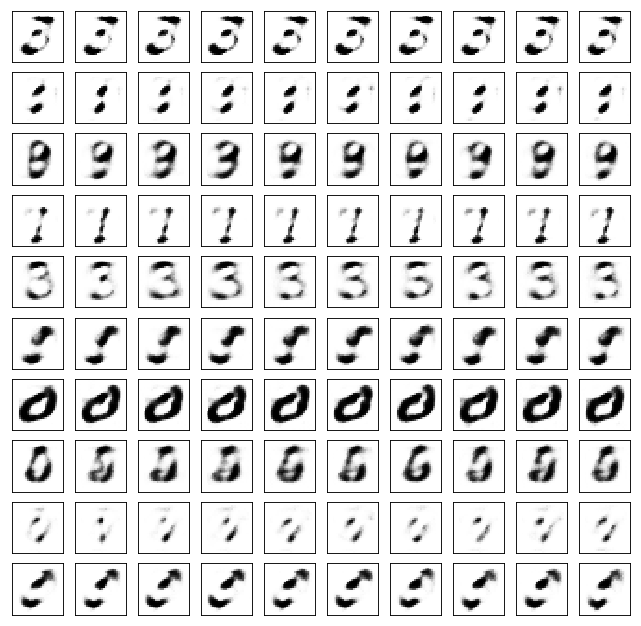

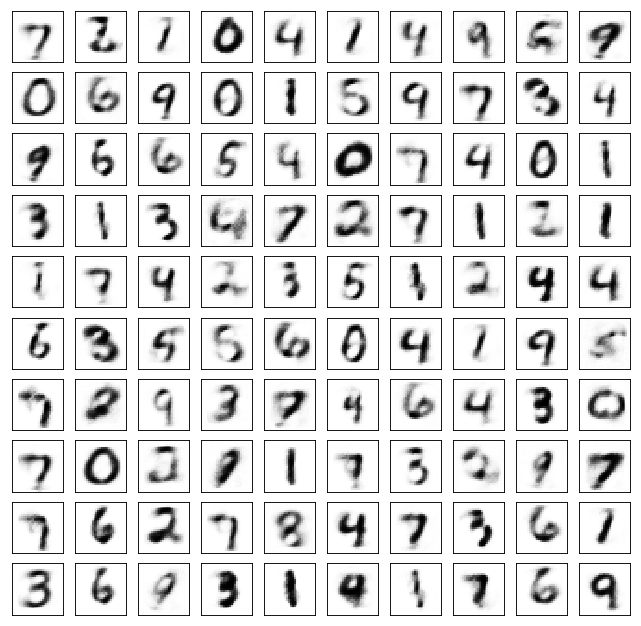

Test losses. E: 0.6915, AE: 0.1183, D: 0.7003
Train Epoch: 25 [0/50000 (0%)]	Losses E: 0.6977, AE: 0.1144, D: 0.6996
Train Epoch: 25 [25000/50000 (50%)]	Losses E: 0.6229, AE: 0.1306, D: 0.7256
Train Epoch: 25 [50000/50000 (100%)]	Losses E: 0.7015, AE: 0.1140, D: 0.7020


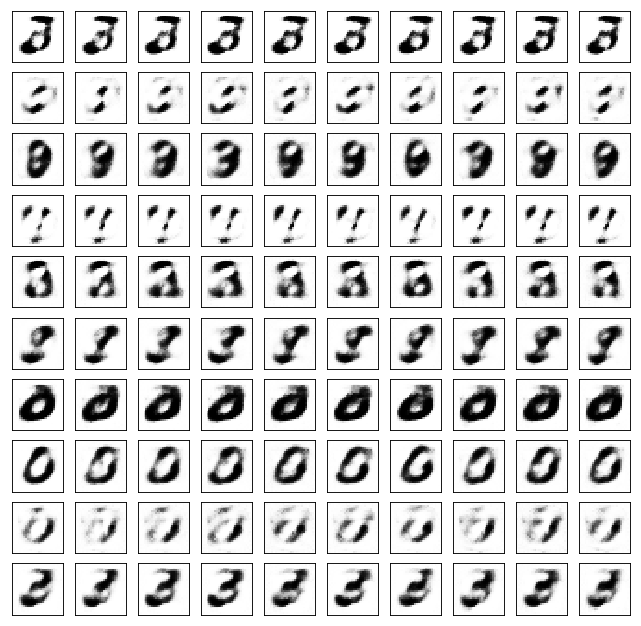

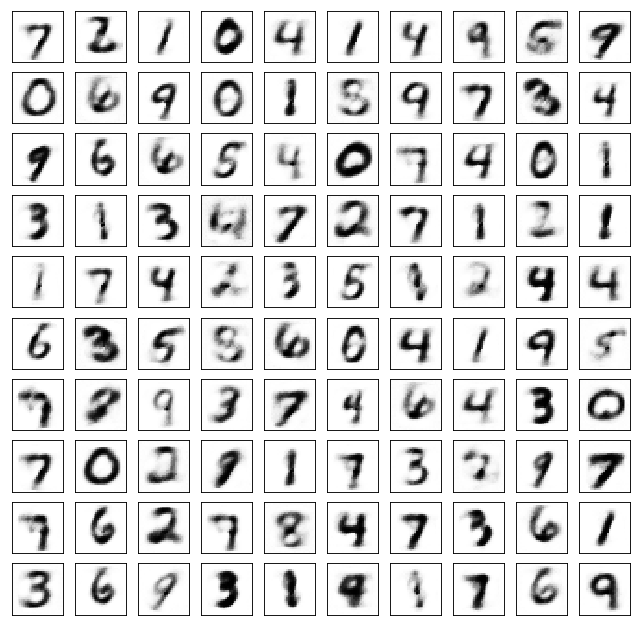

Test losses. E: 0.6980, AE: 0.1134, D: 0.7025
Train Epoch: 26 [0/50000 (0%)]	Losses E: 0.7002, AE: 0.1142, D: 0.7028
Train Epoch: 26 [25000/50000 (50%)]	Losses E: 0.6534, AE: 0.1079, D: 0.6997
Train Epoch: 26 [50000/50000 (100%)]	Losses E: 0.8127, AE: 0.1276, D: 0.6735


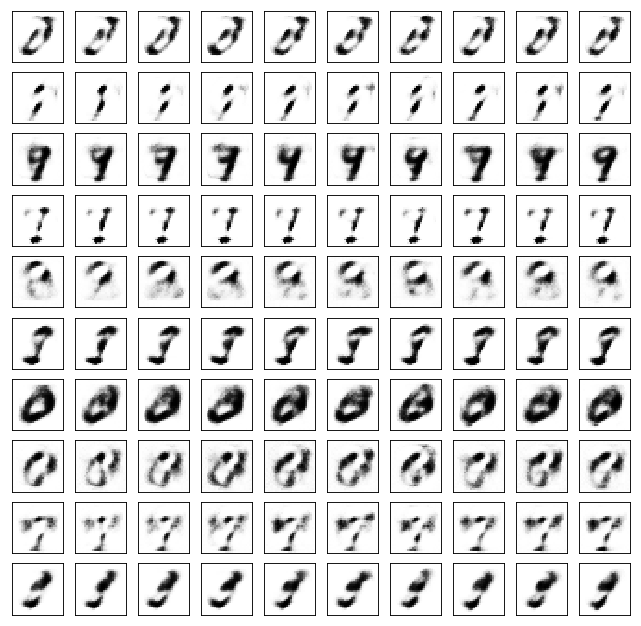

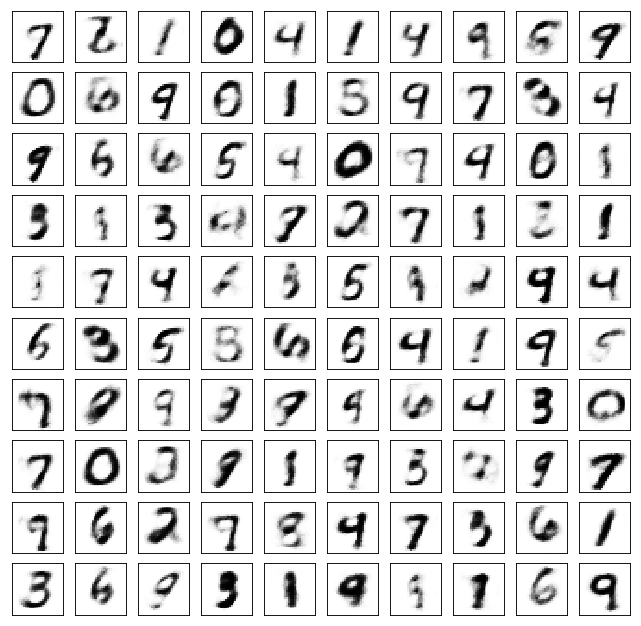

Test losses. E: 0.7842, AE: 0.1280, D: 0.6675
Train Epoch: 27 [0/50000 (0%)]	Losses E: 0.8336, AE: 0.1294, D: 0.6652
Train Epoch: 27 [25000/50000 (50%)]	Losses E: 0.7172, AE: 0.1055, D: 0.7012
Train Epoch: 27 [50000/50000 (100%)]	Losses E: 0.6587, AE: 0.1010, D: 0.6886


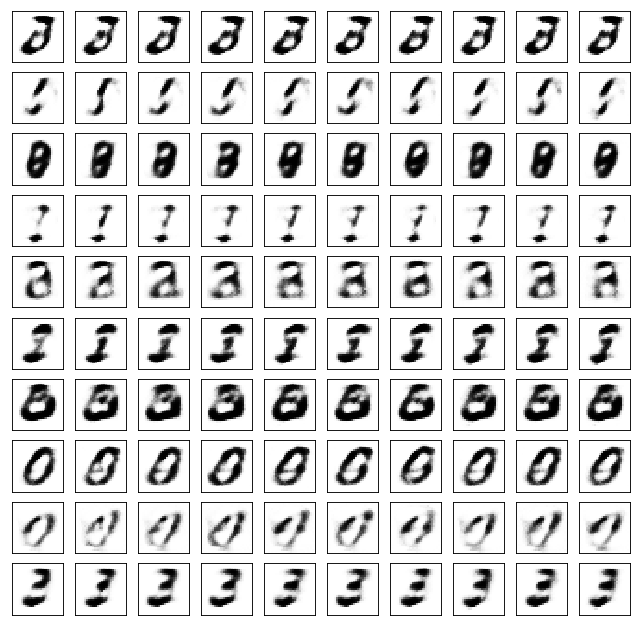

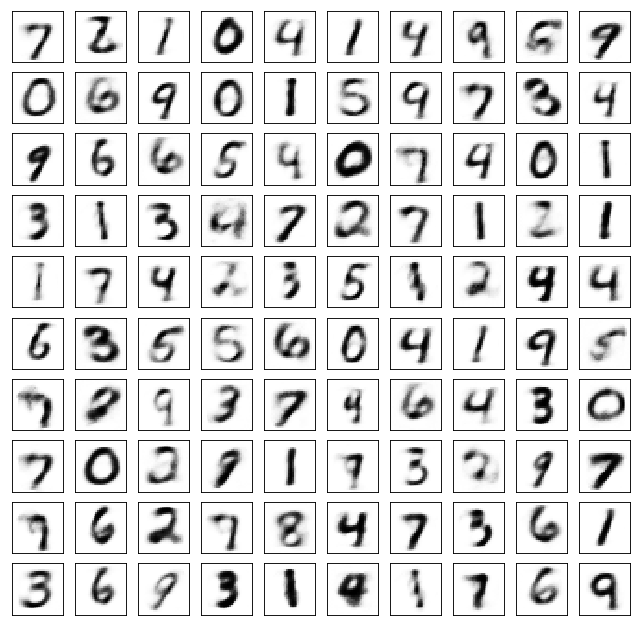

Test losses. E: 0.6587, AE: 0.0997, D: 0.6890
Train Epoch: 28 [0/50000 (0%)]	Losses E: 0.6595, AE: 0.0995, D: 0.6901
Train Epoch: 28 [25000/50000 (50%)]	Losses E: 0.6927, AE: 0.1055, D: 0.6952
Train Epoch: 28 [50000/50000 (100%)]	Losses E: 0.7073, AE: 0.1110, D: 0.7125


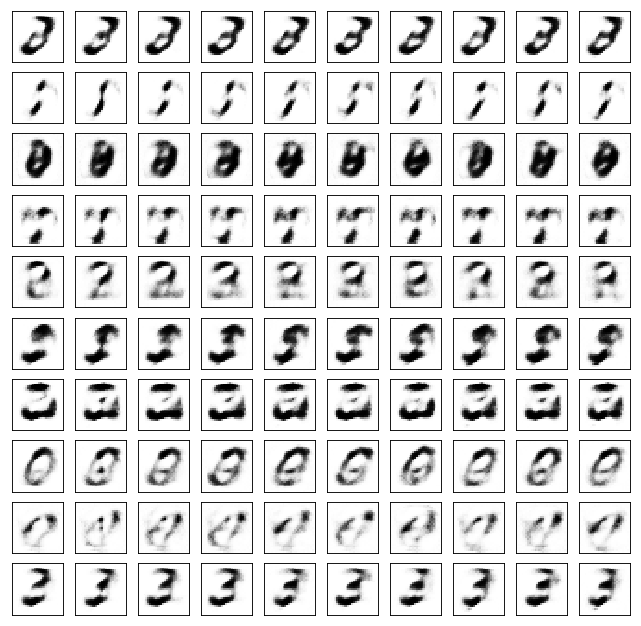

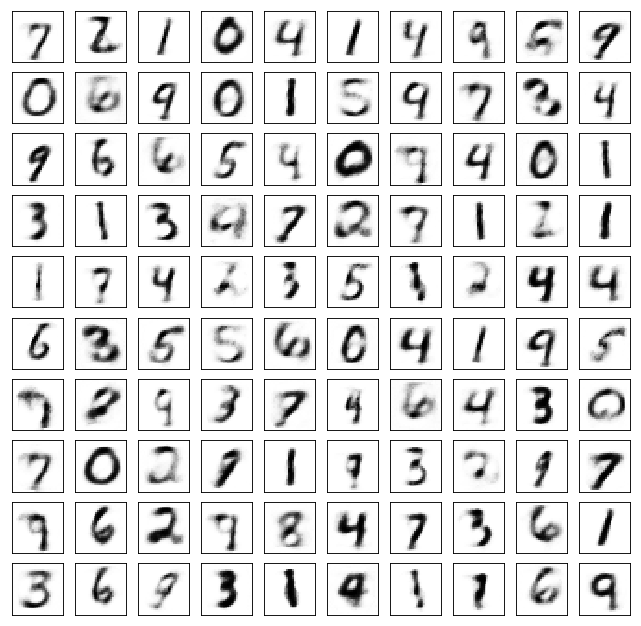

Test losses. E: 0.7066, AE: 0.1104, D: 0.7101
Train Epoch: 29 [0/50000 (0%)]	Losses E: 0.7065, AE: 0.1150, D: 0.7095
Train Epoch: 29 [25000/50000 (50%)]	Losses E: 0.6755, AE: 0.0975, D: 0.6900
Train Epoch: 29 [50000/50000 (100%)]	Losses E: 0.6846, AE: 0.0997, D: 0.6886


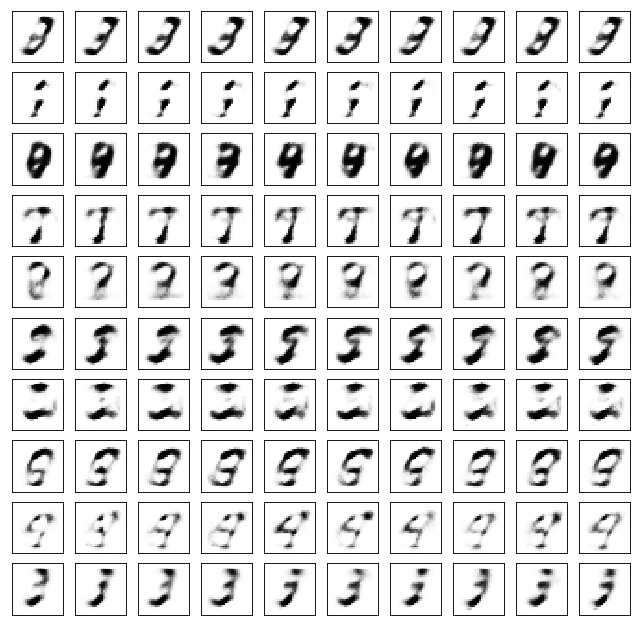

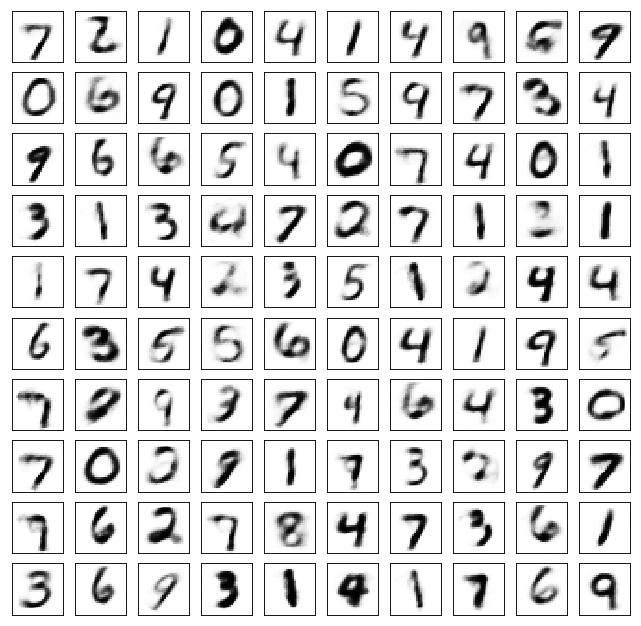

Test losses. E: 0.6832, AE: 0.0973, D: 0.6891
Train Epoch: 30 [0/50000 (0%)]	Losses E: 0.6841, AE: 0.0966, D: 0.6895
Train Epoch: 30 [25000/50000 (50%)]	Losses E: 0.6935, AE: 0.0916, D: 0.7016
Train Epoch: 30 [50000/50000 (100%)]	Losses E: 0.6939, AE: 0.0948, D: 0.6900


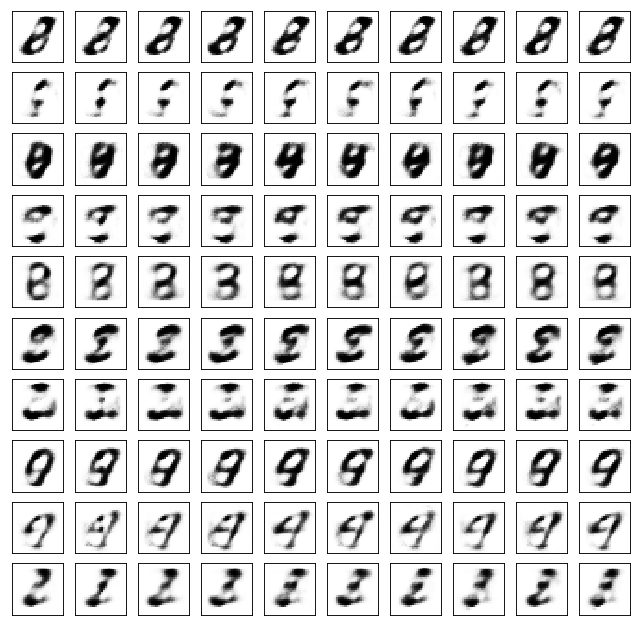

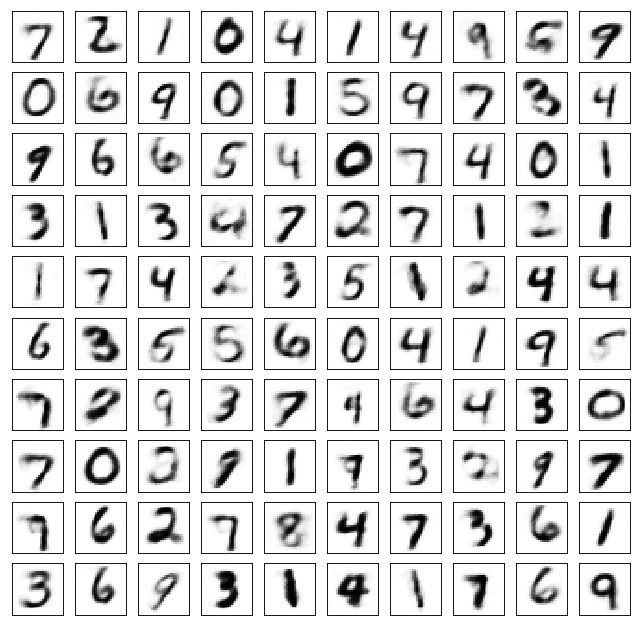

Test losses. E: 0.6923, AE: 0.0931, D: 0.6908
Train Epoch: 31 [0/50000 (0%)]	Losses E: 0.6934, AE: 0.0922, D: 0.6906
Train Epoch: 31 [25000/50000 (50%)]	Losses E: 0.7245, AE: 0.1058, D: 0.6887
Train Epoch: 31 [50000/50000 (100%)]	Losses E: 0.7318, AE: 0.0927, D: 0.6901


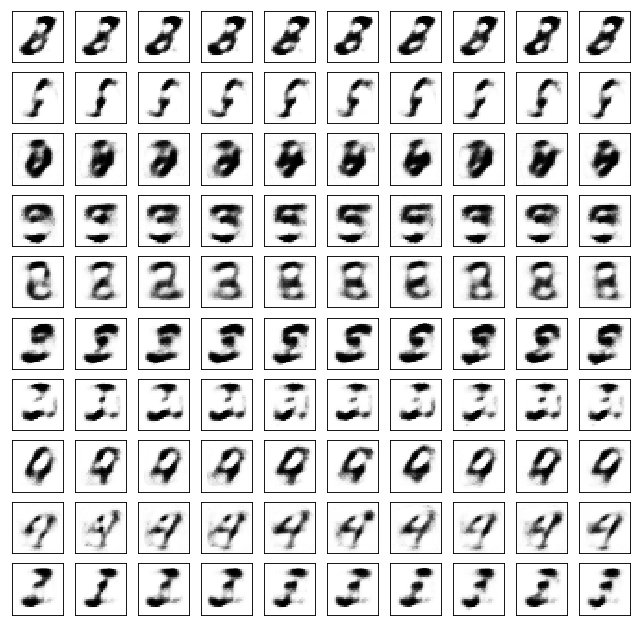

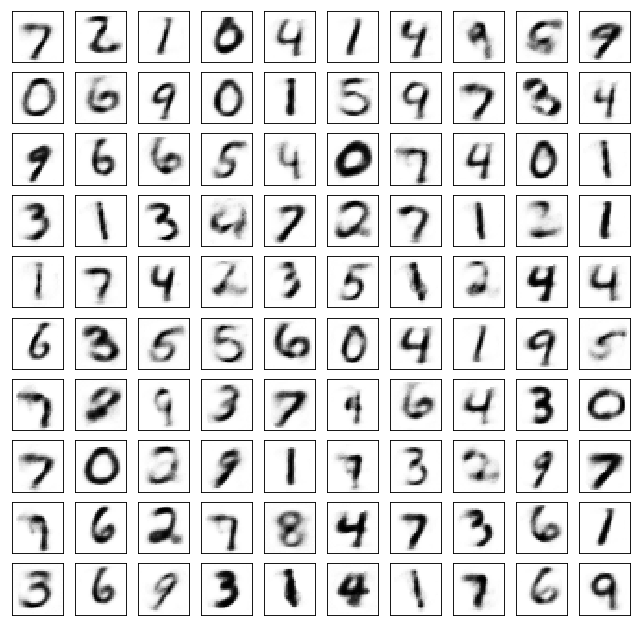

Test losses. E: 0.7282, AE: 0.0961, D: 0.6916
Train Epoch: 32 [0/50000 (0%)]	Losses E: 0.7291, AE: 0.0895, D: 0.6919
Train Epoch: 32 [25000/50000 (50%)]	Losses E: 0.6725, AE: 0.0953, D: 0.6991
Train Epoch: 32 [50000/50000 (100%)]	Losses E: 0.6835, AE: 0.1051, D: 0.7037


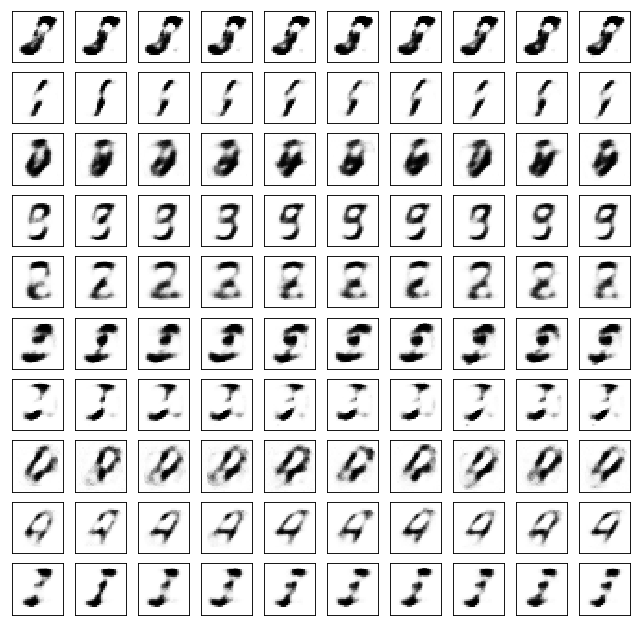

In [ ]:
for epoch in range(1, train_epoch + 1):
    Enc.train()
    Dec.train()
    Disc.train()
    train(epoch, Enc, Dec, Disc, train_log)
    Enc.eval()
    Dec.eval()
    Disc.eval()
    test(Enc, Dec, Disc, valid_loader, epoch, test_log)

In [ ]:
torch.save(Enc, './enc_caae_1')
torch.save(Dec, './dec_caae_1')
torch.save(Disc, './disc_caae_1')